In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# Import Data & Sample

In [2]:
df = pd.read_csv(
    '/kaggle/input/us-used-cars-dataset/used_cars_data.csv',
    parse_dates=['listed_date']
)

df = df[(df['price'] >= 500) &
        (df['price'] <= 200000)]

df.shape

(2997798, 66)

In [3]:
# Randomly sampling 750k points from dataset
df = df.sample(n=750000, random_state=42)
df.shape

(750000, 66)

# EDA

In [4]:
model_data = df.copy()

## `DaysOnMarket`

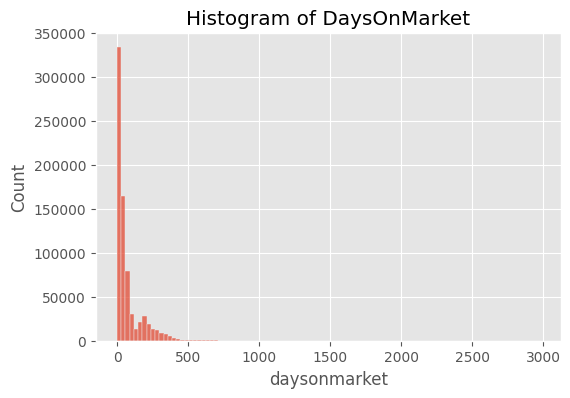

In [5]:
plt.figure(figsize=(6, 4))
sns.histplot(x='daysonmarket', data=model_data, bins=100)
plt.title('Histogram of DaysOnMarket')
plt.show()

In [6]:
# 90% of the listings are on the market for less than 215 days
model_data['daysonmarket'].quantile(0.90)

215.0

### Filtering

In [7]:
# Filtering out outliers to prevent any potential biases
model_data = model_data[(model_data['daysonmarket'] <= 215)]

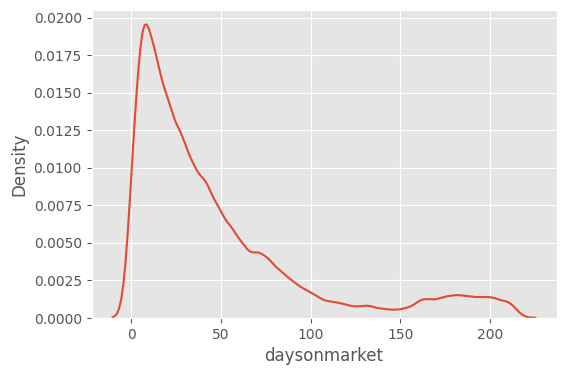

In [8]:
plt.figure(figsize=(6, 4))
sns.kdeplot(x='daysonmarket', data=model_data)
plt.show()

## `Price`

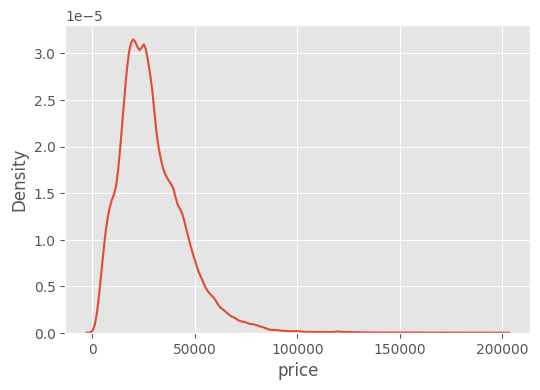

In [9]:
plt.figure(figsize=(6, 4))
sns.kdeplot(model_data['price'])
plt.show()

In [10]:
# 95% of the data is priced below 59k
model_data['price'].quantile(0.95)

58555.0

In [11]:
model_data = model_data[(model_data['price'] <= 59000)]

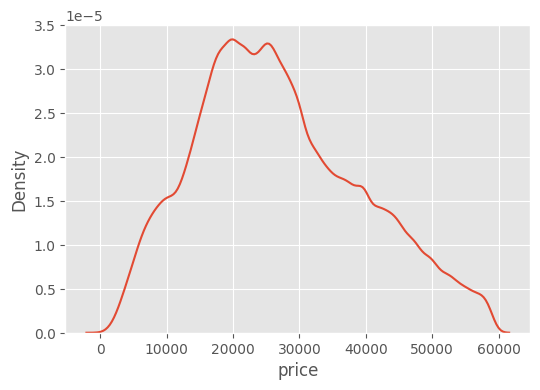

In [12]:
plt.figure(figsize=(6, 4))
sns.kdeplot(model_data['price'])
plt.show()

### Final Model Data

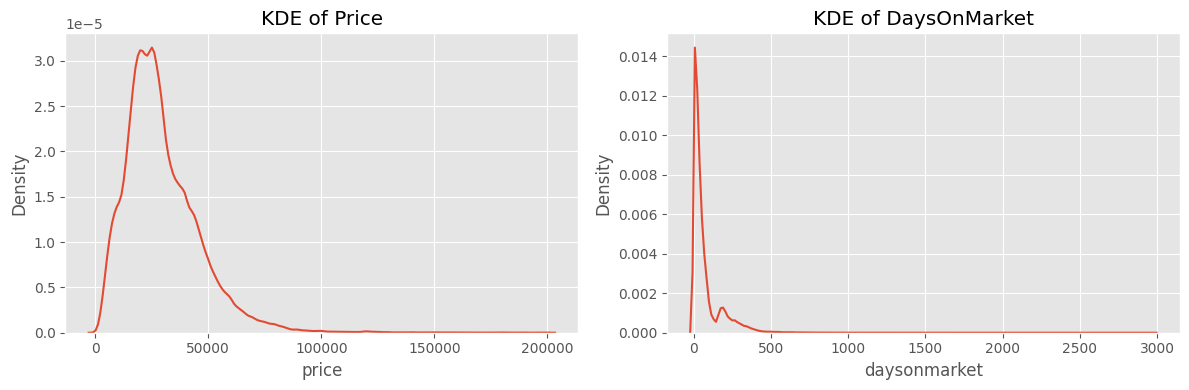

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(df['price'], ax=axes[0])
axes[0].set_title('KDE of Price')

sns.kdeplot(df['daysonmarket'], ax=axes[1])
axes[1].set_title('KDE of DaysOnMarket')

plt.tight_layout()
plt.show()

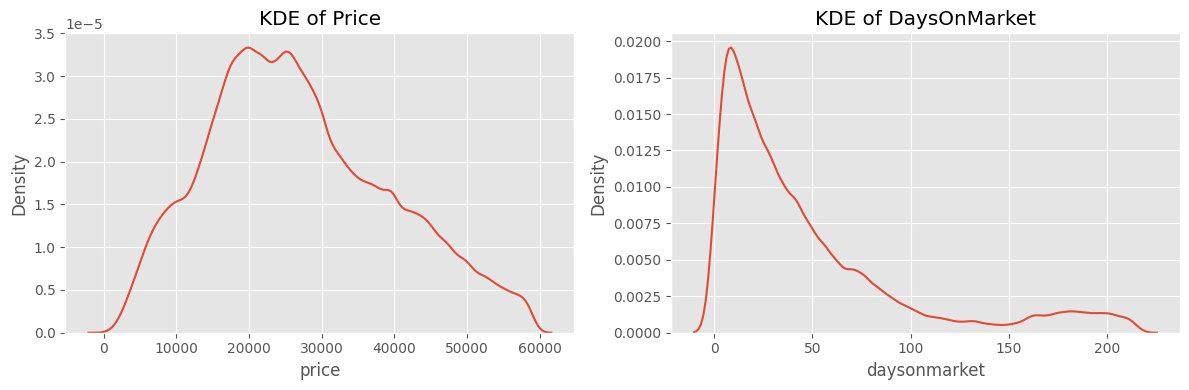

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(model_data['price'], ax=axes[0])
axes[0].set_title('KDE of Price')

sns.kdeplot(model_data['daysonmarket'], ax=axes[1])
axes[1].set_title('KDE of DaysOnMarket')

plt.tight_layout()
plt.show()

## Applying Transformation

#### Log1p

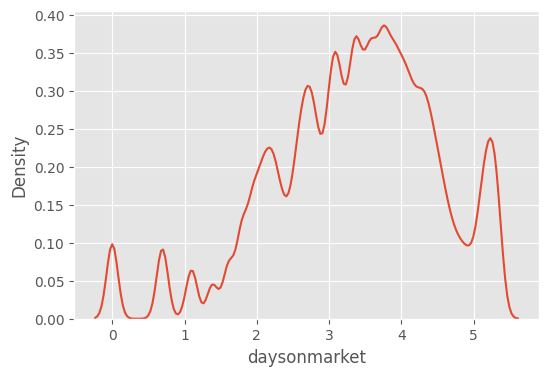

In [14]:
log_trans_daysonmarket = np.log1p(model_data['daysonmarket'])

plt.figure(figsize=(6, 4))
sns.kdeplot(log_trans_daysonmarket)
plt.show()

#### Box-cox & Yeo-Johnson

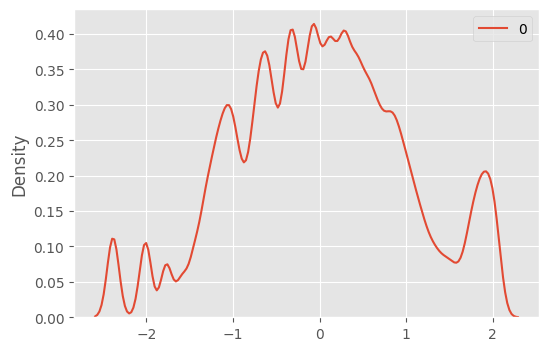

In [15]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")
yj_trans_daysonmarket = pt.fit_transform(model_data['daysonmarket'].values.reshape(-1,1))

plt.figure(figsize=(6, 4))
sns.kdeplot(yj_trans_daysonmarket)
plt.show()

Degiskenin 0'a biased olmasi nedeni ile `log1p` sonucu yine skewed bir dagilim elde ediyoruz, `Yeo-Jhonson` ile birlikte normal dagilima daha yakin bir sonuc elde etmis oluyoruz.

Lineer Regresyonun sahip oldugu normal dagilim varsayimini ele alirsak, `Yeo-Jhonson` donusumu sonucu elde edilen degerler ile ilerlemek daha dogru olabilir.

In [16]:
pt = PowerTransformer(method="yeo-johnson")
model_data['daysonmarket_trans'] = pt.fit_transform(model_data['daysonmarket'].values.reshape(-1,1))

## DaysOnMarket x Price

### Correlation

In [17]:
model_data[['daysonmarket_trans', 'price']].corr(method='pearson')

,daysonmarket_trans,price
daysonmarket_trans,1.000,0.006
price,0.006,1.000


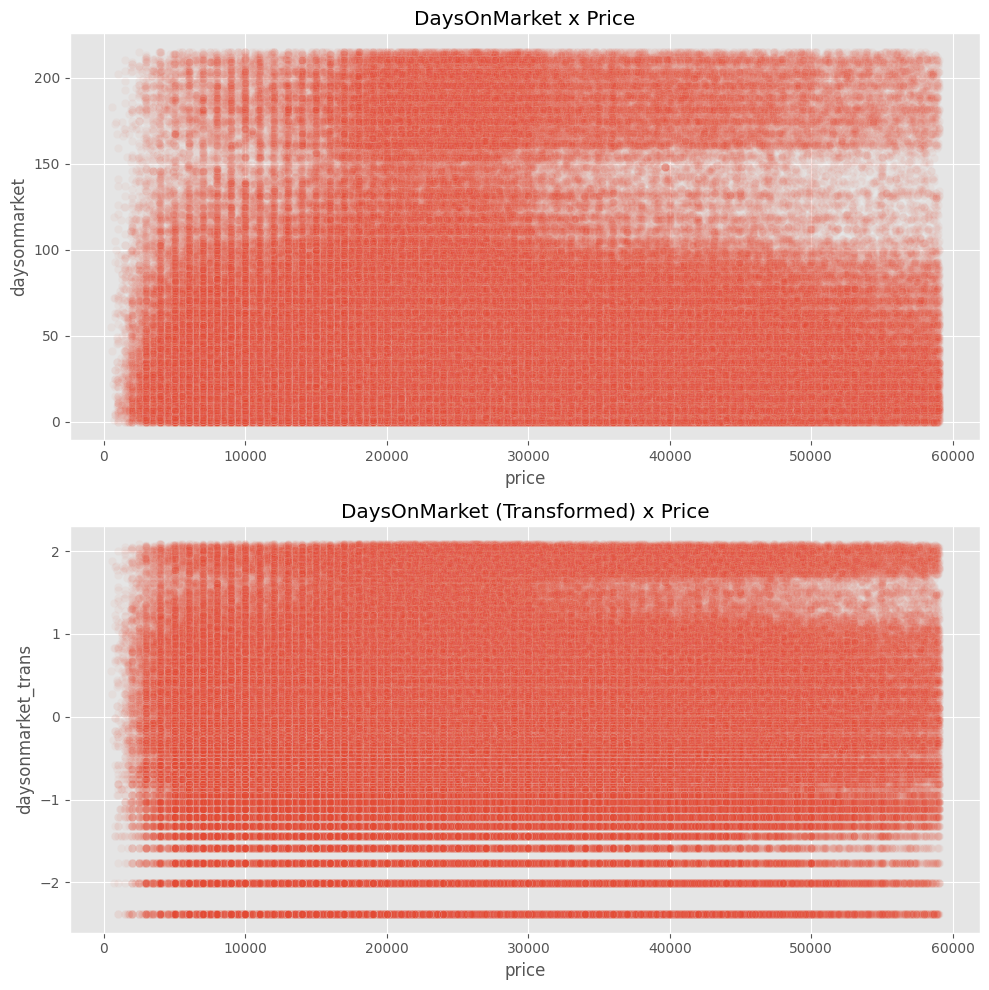

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.scatterplot(x='price', y='daysonmarket', data=model_data, alpha=0.05, ax=axes[0])
axes[0].set_title('DaysOnMarket x Price')

sns.scatterplot(x='price', y='daysonmarket_trans', data=model_data, alpha=0.05, ax=axes[1])
axes[1].set_title('DaysOnMarket (Transformed) x Price')

plt.tight_layout()
plt.show()

In [19]:
# Creating Price Groups
model_data['price_group'] = (model_data['price'] // 10000).astype(int)

price_map = {}
for i in range(20):
    price_map[i] = f'{i*10000}-{(i+1)*10000} USD'

model_data['price_group'] = model_data['price_group'].map(price_map)

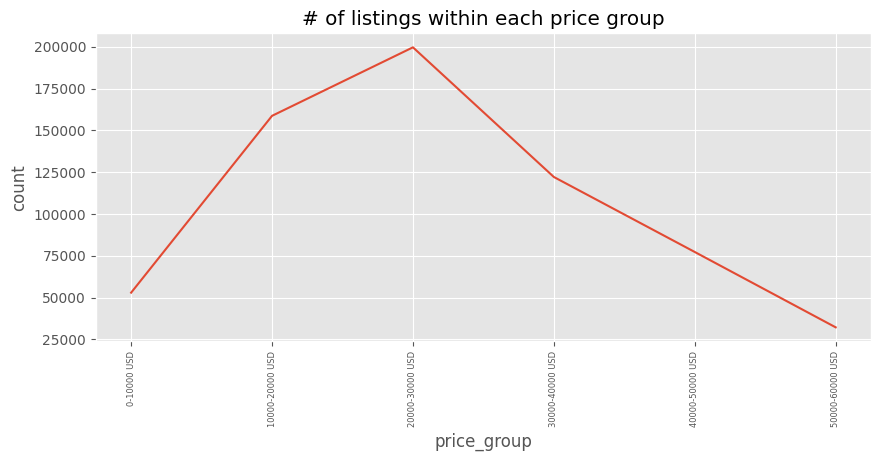

In [20]:
cnts = (
    model_data['price_group']
    .value_counts()
    .sort_index(key=lambda idx: idx.str.split('-').str[0].astype(int))
).reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x='price_group', y='count', data=cnts)
plt.title('# of listings within each price group')
plt.xticks(rotation=90, fontsize=6);

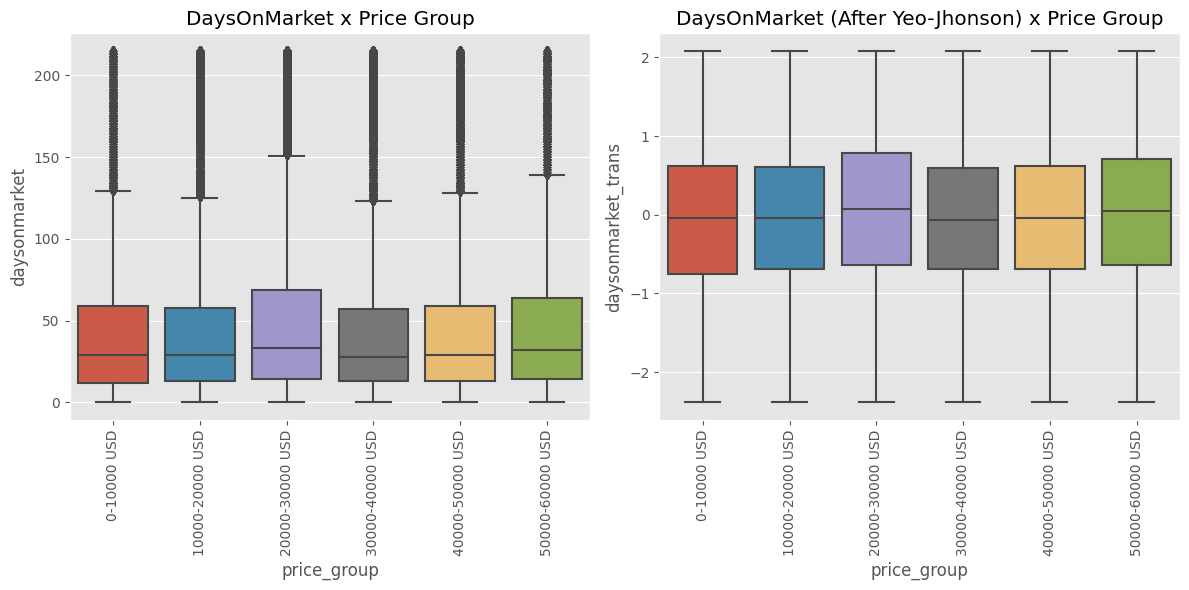

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

order = sorted(model_data["price_group"].unique(), key=lambda x: int(x.split("-")[0])) # ??

sns.boxplot(x='price_group', y='daysonmarket', data=model_data, order=order, ax=axes[0])
axes[0].set_title('DaysOnMarket x Price Group')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.boxplot(x='price_group', y='daysonmarket_trans', data=model_data, order=order, ax=axes[1])
axes[1].set_title('DaysOnMarket (After Yeo-Jhonson) x Price Group')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

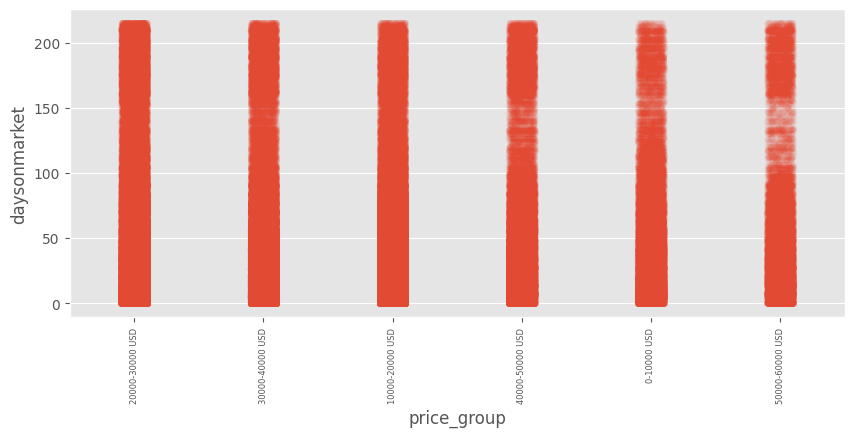

In [22]:
plt.figure(figsize=(10, 4))
sns.stripplot(x='price_group', y='daysonmarket', data=model_data, jitter=True, alpha=0.05)
plt.xticks(rotation=90, fontsize=6);

# Regression

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

In [24]:
scaler_dict = {}
for col in ['price', 'daysonmarket_trans']:
    scaler_dict[col] = MinMaxScaler()
    model_data[f'{col}_scaled'] = scaler_dict[col].fit_transform(model_data[col].values.reshape(-1, 1))

X = model_data[['price_scaled']]
y = model_data['daysonmarket_trans_scaled']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Checking Statistical Availability (OLS Regression)

In [26]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     daysonmarket_trans_scaled   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                  0.000
Method:                        Least Squares   F-statistic:                     27.17
Date:                       Wed, 10 Sep 2025   Prob (F-statistic):           1.87e-07
Time:                               10:32:03   Log-Likelihood:                 40228.
No. Observations:                     514420   AIC:                        -8.045e+04
Df Residuals:                         514418   BIC:                        -8.043e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5304      0.001    727.398      0.000       0.529       0.532
price_scaled     0.0076      0.001      5.212      0.000       0.005       0.010
==============================================================================
Omnibus:                     3332.098   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2317.364
Skew:                          -0.021   Prob(JB):                         0.00
Kurtosis:                       2.674   Cond. No.                         5.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Elimizdeki veri dogrultusunda iki degisken arasinda bir baglanti bulunmamaktadir. Fiyat'in hedef degisken uzerinde sahip oldugu aciklanan varyans miktari (R2) 0 degerini almaktadir ve OLS regresyon sonucu fiyatin katsayi degeri 0'a yakinsamaktadir. Bu durumda diger degiskenlerin dahil edilmesi dusunulebilir.

In [27]:
model_data.corr(method='spearman', numeric_only=True)[['daysonmarket']]

,daysonmarket
city_fuel_economy,0.060386
combine_fuel_economy,NaN
daysonmarket,1.000000
engine_displacement,-0.091046
franchise_dealer,-0.005130
highway_fuel_economy,0.047575
horsepower,-0.075455
is_certified,NaN
is_new,0.150323
latitude,-0.000055


## Model Training

In [28]:
lm = LinearRegression(fit_intercept=True)

lm.fit(X_train, y_train)

train_preds = lm.predict(X_train)
test_preds = lm.predict(X_test)

train_mse = mean_squared_error(y_train, train_preds)
test_mse  = mean_squared_error(y_test, test_preds)

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print('Training Results')
print('\tTrain MSE:', round(train_mse, 3))
print('\tTest MSE:', round(test_mse, 3))
print('\tTrain R2:', round(train_r2, 3))
print('\tTest R2:', round(test_r2, 3))

Training Results
	Train MSE: 0.05
	Test MSE: 0.05
	Train R2: 0.0
	Test R2: -0.0


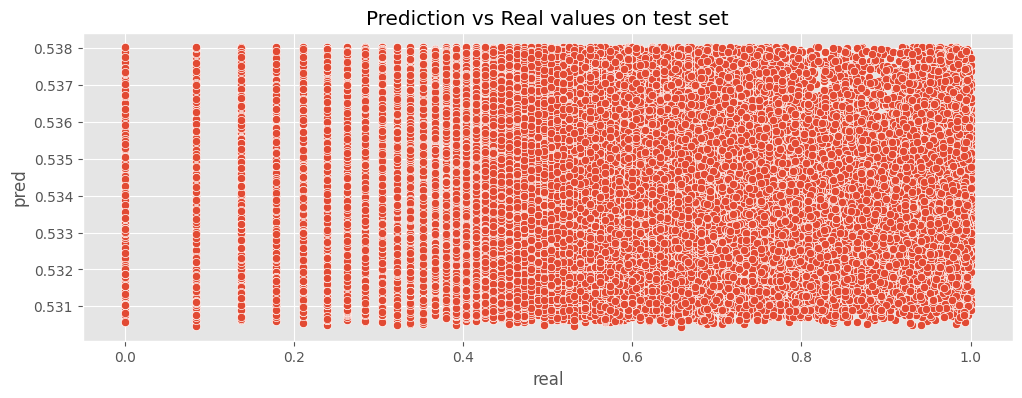

In [29]:
submission = pd.DataFrame({
    'real': y_test.values,
    'pred': test_preds
})

fig = plt.figure(figsize=(12, 4))

sns.scatterplot(x='real', y='pred', data=submission)
plt.title('Prediction vs Real values on test set')
plt.show()

## Simulation

In [43]:
cols = []

for ratio in [0.05, 0.1, 0.15]:
    model_data[f'price_{1-ratio}_lower'] = model_data['price'] * (1-ratio)
    cols += [f'price_{1-ratio}_lower']

In [69]:
preds = {}

for col in cols:
    modified_test_set = model_data.loc[X_test.index][col]
    scaled_values = scaler_dict['price'].transform(modified_test_set.values.reshape(-1, 1))

    new_pred = lm.predict(scaled_values)
    new_pred = scaler_dict['daysonmarket_trans'].inverse_transform(new_pred.reshape(-1, 1))
    new_pred = pt.inverse_transform(new_pred.reshape(-1, 1))
    preds[col] = new_pred

In [70]:
preds

{'price_0.95_lower': array([[30.19451048],
        [30.3680606 ],
        [30.15679467],
        ...,
        [30.22843623],
        [30.1004517 ],
        [30.13803562]]),
 'price_0.9_lower': array([[30.17766019],
        [30.34198239],
        [30.1419445 ],
        ...,
        [30.20978518],
        [30.08858599],
        [30.12417957]]),
 'price_0.85_lower': array([[30.16081745],
        [30.3159222 ],
        [30.12710022],
        ...,
        [30.19114339],
        [30.07672403],
        [30.11032866]])}